# Reading the ROOT files

In [418]:
# %matplotlib notebook

In [1]:
import uproot
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import awkward as ak

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

In [4]:
from scipy.ndimage import median as med

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import IPython
from matplotlib import cm

In [6]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [7]:
fastn = uproot.open('data/fastn.root'+':data')
sing = uproot.open('data/singles.root'+':data')
eplus = uproot.open('data/e+.root'+':data')
eminus = uproot.open('data/e-.root'+':data')
fastnsing = uproot.open('data/fastn_singles.root'+':data')

In [8]:
neutrons = fastn.arrays(library='awkward')
singles = sing.arrays(library='awkward')#[:20000]
positrons = eplus.arrays(library='awkward')#[:20000]
electrons = eminus.arrays(library='awkward')
# singles['channel']=singles['channel']-1 #need to reprocess..

In [9]:
nsing = fastnsing.arrays(library='awkward')
moresingles = nsing[nsing['code']==4]
moreneutrons = nsing[nsing['code']==2]

In [10]:
singles = ak.concatenate([singles, moresingles])
neutrons = ak.concatenate([neutrons, moreneutrons])

In [11]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([neutrons, singles, positrons]):
    print('set %i of %i'%(j+1, 3))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]
    data = data[data['inner_hit']>0]

set 1 of 3
set 2 of 3
set 3 of 3


In [12]:
neutrons = neutrons[neutrons['inner_hit']>0]

In [78]:
data = positrons

## Trying to get n9 PMTs

In [288]:
c = 21.8 #cm/ns

In [302]:
pmtpos

array([[  25.        ,   25.        ,  570.        ],
       [ -25.        ,   25.        ,  570.        ],
       [  25.        ,  -25.        ,  570.        ],
       ...,
       [ 561.09539795, -100.35905457, -526.        ],
       [ 567.76947021,  -50.37665939,  526.        ],
       [ 567.76947021,  -50.37665939, -526.        ]])

In [289]:
chn = data['channel']


In [290]:
i=320
xyz = pmtpos[chn[i]] #cm
vertex = [data['x'][i]/10, data['y'][i]/10, data['z'][i]/10] #cm
dist = np.sqrt(np.sum((xyz - vertex)**2, axis=1)) # cm

In [291]:
t = data['t'][i] #ns
times = data['hittime'][i]-800.-t #ns

In [292]:
data['id_plus_dr_hit'][i]

52

In [293]:
data['n9'][i]

48.0

In [294]:
res = times - dist/c

In [295]:
n9mask = np.logical_and(res<6, res>-3)

In [296]:
chn[i][n9mask]

<Array [474, 1077, 1700, 990] type='4 * int32'>

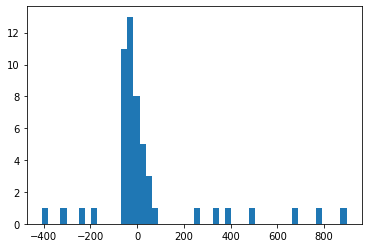

In [297]:
plt.hist(res, bins=50)
plt.show()

## Random Forests

In [36]:
wht = get_dims(neutrons)

Remaining variables selected for analysis: 17


In [42]:
wht = wht[wht['inner_hit']>0]

In [43]:
wht

<Array [{n9: 21, ... azimuth_ks: 0.198}] type='7797 * {"n9": float64, "n9_prev":...'>

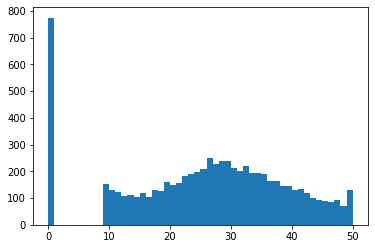

In [39]:
plt.hist(wht['inner_hit'], bins=np.linspace(0,50,51))
plt.show()

In [27]:
ak.to_pandas(wht)

,n9,n9_prev,x,y,z,inner_hit,inner_hit_prev,good_dir,good_dir_prev,good_pos,good_pos_prev,closestPMT,closestPMT_prev,drPrevr,dzPrevz,dt_prev_us,azimuth_ks
entry,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.732051e+09,1.000000e+09,0.00,0.000000
1,0.0,0.0,-1.000000e+09,-1.000000e+09,-1.000000e+09,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.732051e+09,-1.000000e+09,0.00,0.000000
2,21.0,0.0,2.968523e+03,-3.966793e+03,4.215624e+02,24,0,0.381884,0.000000,0.881437,0.000000,745.449176,0.000000,1.732050e+09,1.000000e+09,15265526.25,0.207267
3,43.0,21.0,5.847311e+02,-2.494803e+03,-3.754795e+03,62,24,0.350143,0.381884,0.708972,0.881437,1945.204773,745.449176,5.029034e+03,-4.176358e+03,3006019.25,0.131993
4,27.0,43.0,6.511618e+02,-1.852126e+03,-3.071395e+03,36,62,0.503877,0.350143,0.740248,0.708972,2628.605347,1945.204773,9.404697e+02,6.834006e+02,4.75,0.222792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8566,12.0,5.0,2.307190e+03,-4.365247e+03,7.642422e+02,12,10,0.367426,0.470314,0.850762,0.582954,762.539869,985.417175,1.053195e+04,5.478825e+03,9496.25,0.140887
8567,33.0,12.0,2.229100e+03,-3.938447e+03,-1.273822e+03,43,12,0.304518,0.367426,0.769864,0.850762,1174.488630,762.539869,2.083738e+03,-2.038064e+03,9029.50,0.358745
8568,12.0,2.0,-9.415099e+02,4.830877e+03,2.208050e+03,12,10,0.445177,0.329102,0.889763,0.317615,778.230875,1938.947972,9.357707e+03,3.492501e+03,73396.25,0.381286


In [150]:
def calcr(data):
    data['r'] = np.sqrt(data['x']**2+data['y']**2)
    return data

In [161]:
s2 = calcr(s2)
fastn = calcr(fastn)

/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [20]:
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [16]:
dimensions = [
    'n9', 'n9_prev',
    'x', 'y', 'z',  # 't',
    'inner_hit', 'inner_hit_prev', 
    'good_dir', 'good_dir_prev', 
    'good_pos', 'good_pos_prev', 
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', #'closestPMT_next', 
    'drPrevr', 'dzPrevz',
    'dt_prev_us', 
    'azimuth_ks', 
    
]

In [178]:
ibd2 = get_dims(s2, dimensions=dimensions).iloc[0:len(fastn)]
fast = get_dims(fastn, dimensions=dimensions)

Remaining variables selected for analysis: 18
Remaining variables selected for analysis: 18


In [179]:
y = np.zeros(len(ibd2))
y = np.append(y, np.ones(len(fast)))

In [180]:
x = pd.concat([ibd2, fast])

In [181]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [182]:
X_save = X_test

In [183]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [184]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50, max_depth=8)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [185]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 97.59%
Test Accuracy: 96.35%


In [186]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

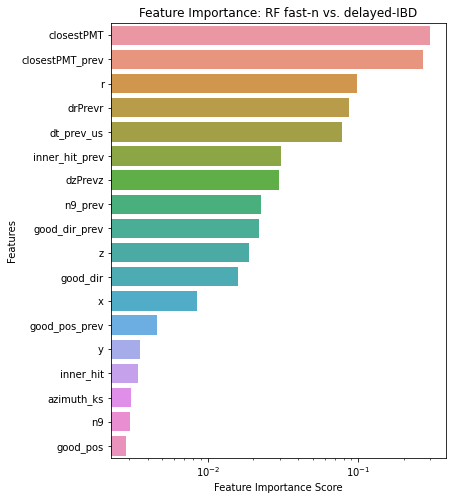

In [187]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-n vs. delayed-IBD")
# plt.legend()
plt.show()

## Mapping hit PMTs with their respective charges

In [14]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',')

In [9]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

In [10]:
Xc,Yc,Zc = data_for_cylinder_along_z(0,0,569,569)

In [11]:
def lines_from_origin(x, y, z, ax):
    for i in range(0, len(x)):
        x_val, y_val, z_val = x[i],y[i],z[i]
        ax.plot([vertex[0],x_val],[vertex[1],y_val],zs=[vertex[2],z_val], color="pink")

In [85]:
data = singles

In [127]:
data = neutrons

In [66]:
delay=1000

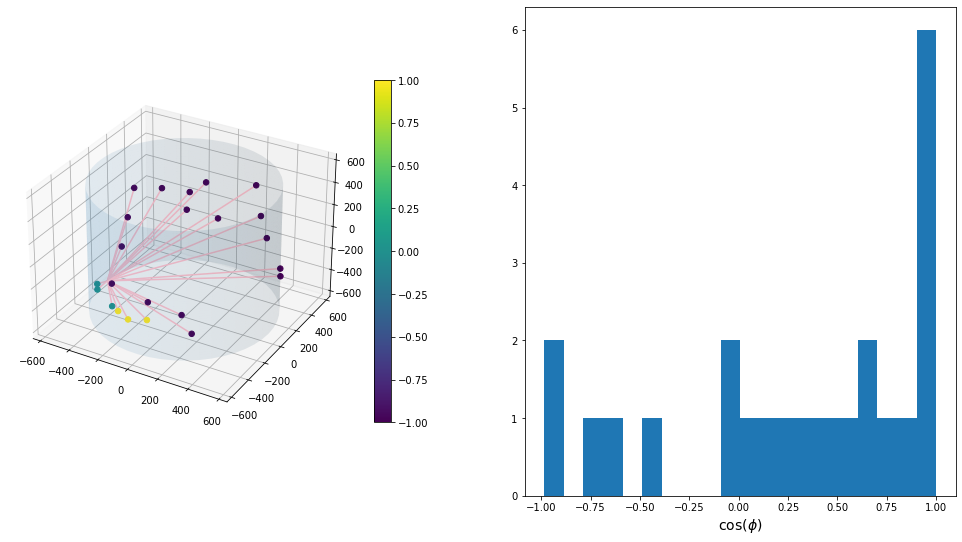

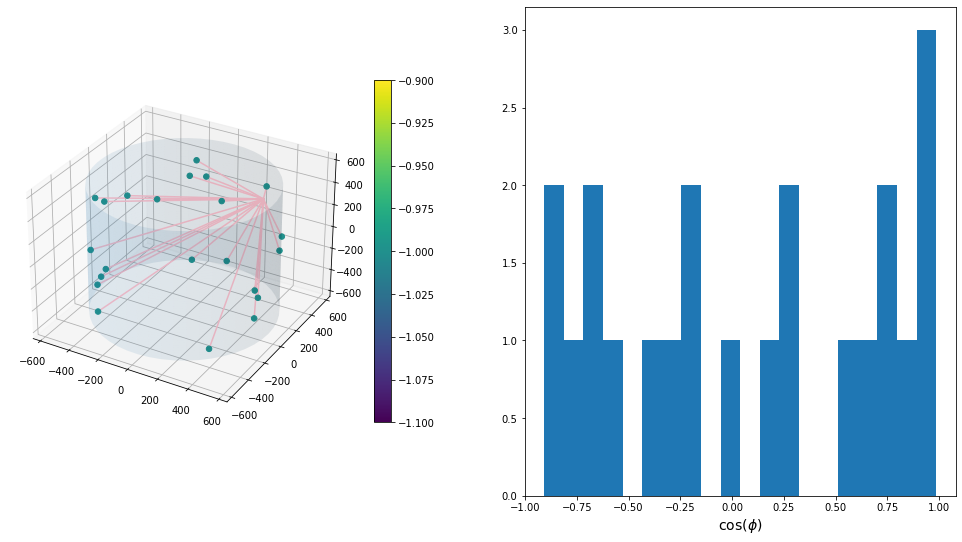

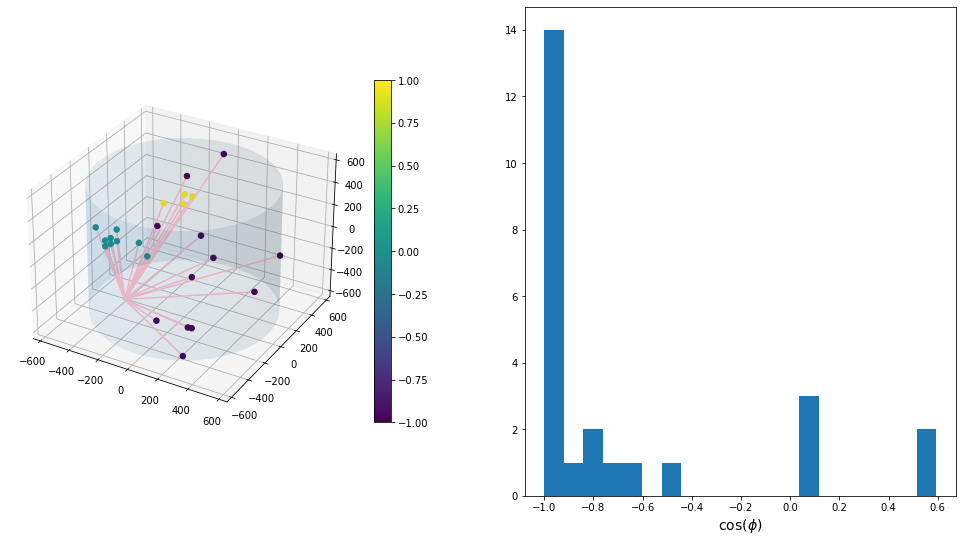

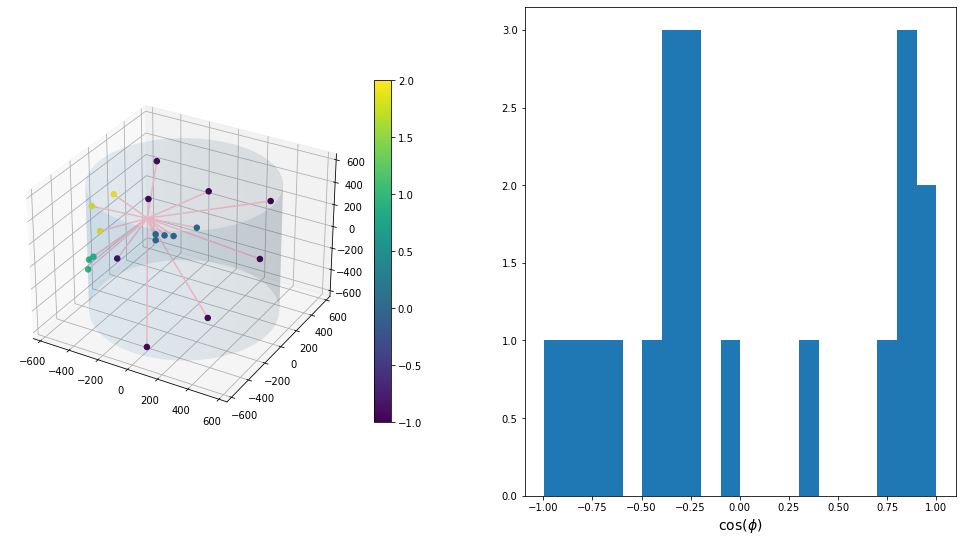

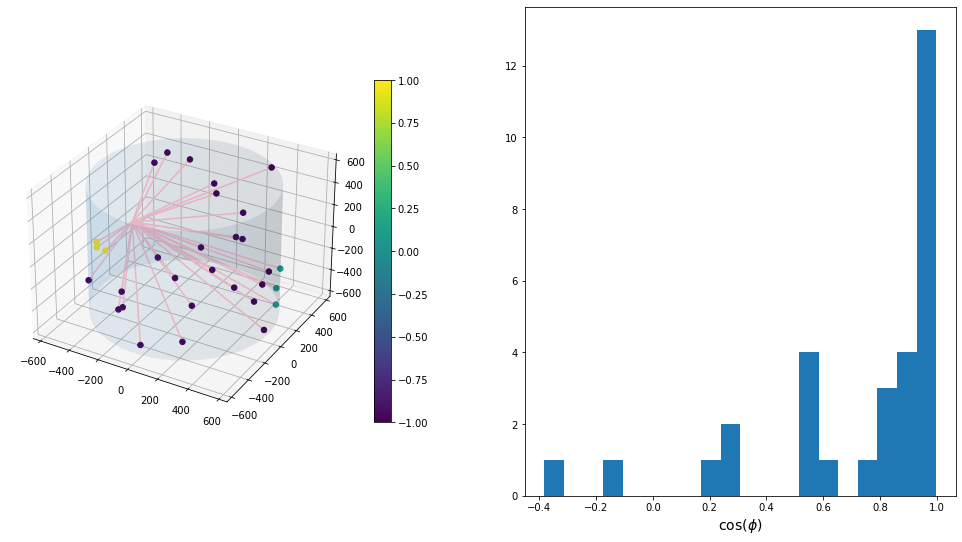

In [88]:
for i in range(2,7):
    ht = data['hittime'][i]
    median = med(ht)
    ht = np.asarray(ht)
    prompt_mask = np.logical_and(ht>median-delay, ht<median+delay)
    
    xyz = pmtpos[data['channel'][i]][prompt_mask]
    u,v,w = data['u'][i], data['v'][i], data['w'][i]
    charge = data['pmtcharge'][i][prompt_mask]
    vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.]
    db = DBSCAN(eps=2, min_samples=3).fit(xyz/100)
    labels = db.labels_
    fig = plt.figure(figsize=(17,9))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(Xc, Yc, Zc, alpha=0.1)
    scat = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], alpha=1, c=labels, 
#                       vmin=0., vmax=2., 
                      marker='o', s=30, )
    plt.colorbar(scat, shrink=0.7)
    lines_from_origin(xyz[:,0], xyz[:,1], xyz[:,2], ax)
#     ax.plot([vertex[0],u*100.-vertex[0]],[vertex[1],v*100.-vertex[1]],zs=[vertex[2],w*100.-vertex[2]], color="black")
    
    ax = fig.add_subplot(122)
    phis = get_azimuth()
    plt.hist(np.cos(phis), bins=20)
    ax.set_xlabel('cos($\phi$)', fontsize=14)
#     ax.plot([vertex[1],v*570.-vertex[1]],[vertex[0],u*570.-vertex[0]],zs=[vertex[2],w*570.-vertex[2]], color="black")    
    
    plt.show()

In [17]:
def get_azimuth(simple=True):
    rad=u**2+v**2
    if rad>0:
        rad = np.sqrt(rad)
        cos_phi=u/rad
        sin_phi=v/rad
        rot_xx=w*cos_phi
        rot_xy=w*sin_phi
        rot_xz=-1*np.sqrt((1+w)*(1-w))
        rot_yx = -1*sin_phi
        rot_yy = cos_phi
    else:
        rot_xy=rot_xz=rot_yx=0
        rot_yy=1
        rot_xx=1 if w>0 else -1

    dx = xyz[:,0] - vertex[0]
    dy = xyz[:,1] - vertex[1]
    dz = xyz[:,2] - vertex[2]
    rad = np.sqrt(dx**2+dy**2+dz**2)
    dx /= rad
    dy /= rad
    dz /= rad

    phi = np.arctan2(rot_yx*dx+rot_yy*dy,
                     rot_xx*dx+rot_xy*dy+rot_xz*dz)
    cosphi = np.cos(phi)
    mu_phi, sigma_phi = np.median(cosphi), np.std(cosphi)

    frac_in_std = np.sum(np.logical_and(cosphi<mu_phi+.3, cosphi>mu_phi-.3))/len(cosphi)
    if simple:
        return phi
    else:
        return mu_phi, sigma_phi, frac_in_std
#     print(frac_in_std)

In [308]:
eval_n = dict(mus=[], sigmas=[], frac_in_std=[])
eval_sing = dict(mus=[], sigmas=[], frac_in_std=[])
eval_eplus = dict(mus=[], sigmas=[], frac_in_std=[])

In [309]:
delay=10

In [310]:
for what, evaldict in zip([neutrons, singles, positrons], [eval_n, eval_sing, eval_eplus]):
    for i in range(len(what)):
        ht = what['hittime'][i]
        median = med(ht)
        ht = np.asarray(ht)
        prompt_mask = np.logical_and(ht>median-delay, ht<median+delay)
        xyz = pmtpos[what['channel'][i]][prompt_mask]
        u,v,w = what['u'][i], what['v'][i], what['w'][i]
        charge = what['pmtcharge'][i][prompt_mask]
        vertex = [what['x'][i]/10., what['y'][i]/10., what['z'][i]/10.]
        mu, sigma, fis =get_azimuth(simple=False)
        evaldict['mus'].append(mu)
        evaldict['sigmas'].append(sigma)
        evaldict['frac_in_std'].append(fis)
    evaldict['mus'] = np.asarray(evaldict['mus'])
    evaldict['sigmas'] = np.asarray(evaldict['sigmas'])

<ipython-input-207-a1272e05126e>:9: RuntimeWarning: invalid value encountered in sqrt
  rot_xz=-1*np.sqrt((1+w)*(1-w))
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/sophia/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_

Text(0, 0.5, '$\\sigma$-cos($\\phi$)')

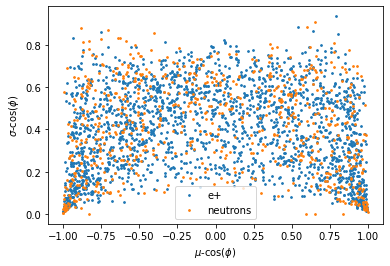

In [314]:

# plt.scatter(eval_sing['mus'][:2000], eval_sing['sigmas'][:2000], 
#             s=3, label='singles')
plt.scatter(eval_eplus['mus'][:2000], eval_eplus['sigmas'][:2000], 
            s=3, label='e+')
plt.scatter(eval_n['mus'], eval_n['sigmas'], 
            s=3, label='neutrons')
plt.legend()
plt.xlabel('$\mu$-cos($\phi$)')
plt.ylabel('$\sigma$-cos($\phi$)')

<ipython-input-315-ca6104247d84>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(eval_n['mus']/eval_n['sigmas'], density=True, bins=np.linspace(-5,5,50), histtype='step')


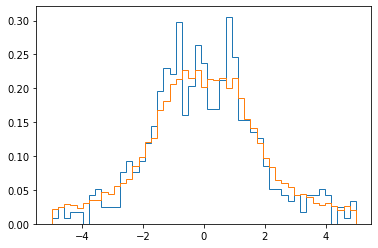

In [315]:
plt.hist(eval_n['mus']/eval_n['sigmas'], density=True, bins=np.linspace(-5,5,50), histtype='step')
plt.hist(eval_eplus['mus']/eval_eplus['sigmas'], density=True, bins=np.linspace(-5,5,50), histtype='step')
plt.show()

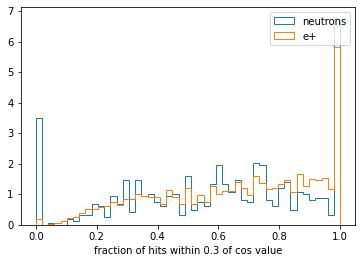

In [316]:
plt.hist(eval_n['frac_in_std'], density=True, 
         bins=np.linspace(0,1,50), histtype='step', label='neutrons')
plt.hist(eval_eplus['frac_in_std'], density=True, 
         bins=np.linspace(0,1,50), histtype='step', label='e+')
plt.legend()
plt.xlabel('fraction of hits within 0.3 of cos value')
# plt.hist(eval_sing['frac_in_std'], density=True, bins=np.linspace(0,1,50), histtype='step')

plt.show()

## Decompose from origin

In [94]:
def get_origin_az(simple=True):
    rad=np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)
    dx = xyz[:,0]/rad
    dy = xyz[:,1]/rad
    dz = xyz[:,2]/rad
    
    theta = np.arctan(dy/dx)
    phi = np.arctan((dx**2+dy**2)/dz)
    return theta, phi
#     print(frac_in_std)

In [119]:
# r, theta, z components. 
r=np.sqrt(xyz[:,0]**2+xyz[:,1]**2)/570
dx = xyz[:,0]/570
dy = xyz[:,1]/570
dz = xyz[:,2]/570
theta = np.arctan2(dy, dx)
# r = np.sqrt(dx**2+dy**2)

In [171]:
time = neutrons['hittime'][6]

In [172]:
time = np.asarray(time).reshape((-1, 1))

In [173]:
db = DBSCAN(eps=10, min_samples=5, ).fit(time)

In [174]:
db.labels_

array([-1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

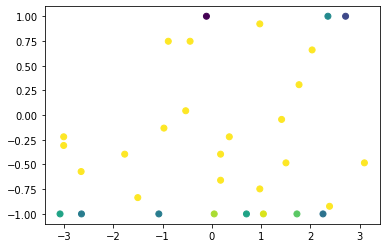

In [175]:
plt.scatter(theta, dz, c=r)

In [103]:
theta, phi = get_origin_az()

(array([ 2.,  0.,  0.,  0.,  1., 12., 28.,  4.,  1.,  1.]),
 array([-0.03452301, -0.02885441, -0.02318581, -0.01751721, -0.01184861,
        -0.00618002, -0.00051142,  0.00515718,  0.01082578,  0.01649438,
         0.02216298]),
 <BarContainer object of 10 artists>)

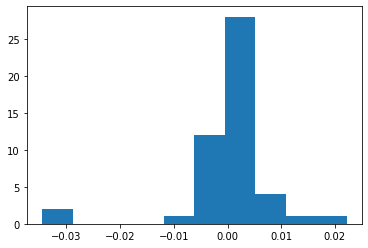

In [189]:
plt.hist(phi)

In [185]:
eval_n = dict(theta=[], phi=[])
eval_sing = dict(theta=[], phi=[])
eval_eplus = dict(theta=[], phi=[])

In [181]:
for what, evaldict in zip([neutrons, singles, positrons], [eval_n, eval_sing, eval_eplus]):
    for i in range(len(what)):
        xyz = pmtpos[what['channel'][i]]
        u,v,w = what['u'][i], what['v'][i], what['w'][i]
        charge = what['pmtcharge'][i]
        vertex = [what['x'][i]/10., what['y'][i]/10., what['z'][i]/10.]
        theta, phi =get_azimuth(simple=False)
        evaldict['mus'].append(mu)
        evaldict['sigmas'].append(sigma)
        evaldict['frac_in_std'].append(fis)

<ipython-input-179-8ad77a899332>:9: RuntimeWarning: invalid value encountered in sqrt
  rot_xz=-1*np.sqrt((1+w)*(1-w))
